In [1]:
# ─── Cell 1: Install required packages ──────────────────────────────────────
%pip install gdown wandb opencv-python tqdm --quiet


Note: you may need to restart the kernel to use updated packages.


In [2]:
# ─── Cell 2: Imports, WandB login & Dataset download ───────────────────────
import os
import cv2
import subprocess
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler      # for LR scheduling
from torchvision import datasets, models
from torchvision.transforms import (
    Compose, Resize, ToTensor, RandomHorizontalFlip,
    RandomRotation, ColorJitter, RandomErasing
)
from torch.utils.data import DataLoader, Subset
import numpy as np
from tqdm import tqdm

# Log in and fetch data
wandb.login(key="9699f0f4bdfee5d846108d559a41e2049bdebc43")
!gdown --id 1iByOjSFL9gevL_6LF1KfzpSpieRViKE3
!unzip -o face_data.zip -d data


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: muditgupta2502 (muditgupta2502-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1iByOjSFL9gevL_6LF1KfzpSpieRViKE3
From (redirected): https://drive.google.com/uc?id=1iByOjSFL9gevL_6LF1KfzpSpieRViKE3&confirm=t&uuid=012a3038-6465-4c63-a7fe-6745875c6cce
To: /kaggle/working/face_data.zip
100%|████████████████████████████████████████| 296M/296M [00:04<00:00, 59.6MB/s]
Archive:  face_data.zip
   creating: data/your_face/
   creating: data/your_face/augmented/
   creating: data/your_face/augmented/bright_light/
   creating: data/your_face/augmented/bright_light/angry/
  inflating: data/your_face/augmented/bright_light/angry/aug_0_image_0000.jpg  
  inflating: data/your_face/augmented/bright_light/angry/aug_0_image_0001.jpg  
  inflating: data/your_face/augmented/bright_light/angry/aug_0_image_

In [3]:
# ─── Cell 3: Device, Transforms & DataLoaders (stronger aug) ───────────────
DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224

# STRONGER train‐time augmentations to regularize
train_tf = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(30),
    ColorJitter(0.5,0.5,0.5,0.2),
    ToTensor(),
    RandomErasing(p=0.5, scale=(0.02,0.3)),
])

# Minimal val/test transforms
val_tf = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor()
])

# Load & split
full_ds = datasets.ImageFolder("data", transform=train_tf)
indices = np.random.RandomState(42).permutation(len(full_ds))
n = len(full_ds)
n_train = int(0.7 * n)
n_val   = int(0.15 * n)

train_ds = Subset(full_ds, indices[:n_train])
val_ds   = Subset(full_ds, indices[n_train:n_train+n_val])
test_ds  = Subset(full_ds, indices[n_train+n_val:])

# swap in val_tf
val_ds.dataset.transform  = val_tf
test_ds.dataset.transform = val_tf

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=0)


In [4]:
# ─── Cell 4: Model Factory (heavier dropout) ────────────────────────────────
def get_model(model_type):
    if model_type == 'vgg16_ft':
        m = models.vgg16(pretrained=False)
        for p in m.features.parameters(): p.requires_grad = False
        m.classifier = nn.Sequential(
            nn.Dropout(0.8),      # stronger
            nn.Linear(25088, 2)
        )
    elif model_type == 'resnet18_scratch':
        m = models.resnet18(pretrained=False)
        m.fc = nn.Sequential(
            nn.Dropout(0.8),
            nn.Linear(512, 2)
        )
    elif model_type == 'resnet18_pretrained':
        m = models.resnet18(pretrained=True)
        for p in m.parameters(): p.requires_grad = False
        for p in m.layer4.parameters(): p.requires_grad = True
        m.fc = nn.Sequential(
            nn.Dropout(0.8),
            nn.Linear(512, 2)
        )
    return m.to(DEVICE)


In [5]:
# ─── Cell 5: Training function with weight‐decay & LR scheduling ───────────
def train_model(model, train_loader, val_loader, name, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=5e-4,              # lower LR
        momentum=0.9,
        weight_decay=0.05     # strong weight decay
    )
    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    wandb.watch(model, log='all')

    best_acc = 0.0
    for ep in range(epochs):
        # TRAIN
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for x,y in tqdm(train_loader, desc=f"[{name}] E{ep+1}/{epochs} Train", leave=False):
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            preds = out.argmax(1)
            correct += (preds==y).sum().item()
            total   += y.size(0)
        tr_acc = correct/total

        # VALIDATE
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x,y in tqdm(val_loader, desc=f"[{name}] E{ep+1}/{epochs} Val", leave=False):
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item()
                preds = out.argmax(1)
                correct += (preds==y).sum().item()
                total   += y.size(0)
        val_acc = correct/total

        # Log & schedule
        scheduler.step()
        wandb.log({
            'epoch': ep+1,
            f'{name}_train_loss': running_loss/len(train_loader),
            f'{name}_val_loss':   val_loss/len(val_loader),
            f'{name}_train_acc':  tr_acc,
            f'{name}_val_acc':    val_acc
        })

        # Save best
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{name}_best.pth")

        print(f"[{name}] E{ep+1}: tr_acc={tr_acc:.3f}, val_acc={val_acc:.3f}")


In [6]:
# ─── Cell 6: Train all three models ─────────────────────────────────────────
wandb.init(project="face_recognition", name="with_regularization")
for mt in ['vgg16_ft','resnet18_scratch','resnet18_pretrained']:
    m = get_model(mt)
    train_model(m, train_loader, val_loader, mt, epochs=5)
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[vgg16_ft] E1: tr_acc=0.842, val_acc=0.955


[vgg16_ft] E2: tr_acc=0.943, val_acc=0.956


[vgg16_ft] E3: tr_acc=0.948, val_acc=0.953


[vgg16_ft] E4: tr_acc=0.948, val_acc=0.960


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[vgg16_ft] E5: tr_acc=0.950, val_acc=0.960


[resnet18_scratch] E1: tr_acc=0.836, val_acc=0.961


[resnet18_scratch] E2: tr_acc=0.948, val_acc=0.944


[resnet18_scratch] E3: tr_acc=0.974, val_acc=0.979


[resnet18_scratch] E4: tr_acc=0.982, val_acc=0.998


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


[resnet18_scratch] E5: tr_acc=0.980, val_acc=0.989


100%|██████████| 44.7M/44.7M [00:00<00:00, 53.4MB/s]


[resnet18_pretrained] E1: tr_acc=0.881, val_acc=0.994


[resnet18_pretrained] E2: tr_acc=0.979, val_acc=0.995


[resnet18_pretrained] E3: tr_acc=0.989, val_acc=0.995


[resnet18_pretrained] E4: tr_acc=0.988, val_acc=0.998


[resnet18_pretrained] E5: tr_acc=0.989, val_acc=0.998


epoch,▁▃▅▆█▁▃▅▆█▁▃▅▆█
resnet18_pretrained_train_acc,▁▇███
resnet18_pretrained_train_loss,█▂▁▁▁
resnet18_pretrained_val_acc,▁▃▃██
resnet18_pretrained_val_loss,█▃▂▁▁
resnet18_scratch_train_acc,▁▆███
resnet18_scratch_train_loss,█▃▁▁▁
resnet18_scratch_val_acc,▃▁▆█▇
resnet18_scratch_val_loss,▆█▂▁▂
vgg16_ft_train_acc,▁████
vgg16_ft_train_loss,█▃▂▁▁


In [7]:
# ─── Cell 7: Evaluation function & loop ─────────────────────────────────────
def evaluate_model(model, loader, name):
    model.eval()
    total, correct = 0, 0
    for x,y in tqdm(loader, desc=f"[{name}] Test", leave=False):
        x,y = x.to(DEVICE), y.to(DEVICE)
        with torch.no_grad():
            preds = model(x).argmax(1)
        correct += (preds==y).sum().item()
        total   += y.size(0)
    acc = correct/total
    wandb.log({f"{name}_test_acc": acc})
    print(f"{name} Test Acc: {acc:.3f}")
    return acc

wandb.init(project="face_recognition", resume="allow")
for mt in ['vgg16_ft','resnet18_scratch','resnet18_pretrained']:
    m = get_model(mt)
    m.load_state_dict(torch.load(f"{mt}_best.pth"))
    evaluate_model(m, test_loader, mt)
wandb.finish()


/tmp/ipykernel_74/3996518643.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(f"{mt}_best.pth"))


vgg16_ft Test Acc: 0.958


resnet18_scratch Test Acc: 0.994


resnet18_pretrained Test Acc: 0.998


resnet18_pretrained_test_acc,▁
resnet18_scratch_test_acc,▁
vgg16_ft_test_acc,▁
resnet18_pretrained_test_acc,0.99839
resnet18_scratch_test_acc,0.99357
vgg16_ft_test_acc,0.9582


In [8]:
# ─── Cell 12: Classification Report & Confusion Matrix ────────────────────
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

for model_type in ['vgg16_ft','resnet18_scratch','resnet18_pretrained']:
    print(f"\n=== {model_type} on Test Set ===")
    # load best weights
    m = get_model(model_type)
    m.load_state_dict(torch.load(f"{model_type}_best.pth"))
    m.eval()

    all_preds, all_true = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(DEVICE)
            logits = m(X)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(y.numpy())

    # report
    print(classification_report(
        all_true, all_preds,
        target_names=full_ds.classes,  # ['not_your_face','your_face']
        digits=4, zero_division=0
    ))
    # confusion matrix
    cm = confusion_matrix(all_true, all_preds, labels=[0,1])
    print("Confusion Matrix:\n", cm)



=== vgg16_ft on Test Set ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_74/2014960950.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

               precision    recall  f1-score   support

not_your_face     0.9521    0.9586    0.9553       290
    your_face     0.9636    0.9578    0.9607       332

     accuracy                         0.9582       622
    macro avg     0.9578    0.9582    0.9580       622
 weighted avg     0.9582    0.9582    0.9582       622

Confusion Matrix:
 [[278  12]
 [ 14 318]]

=== resnet18_scratch on Test Set ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_74/2014960950.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

               precision    recall  f1-score   support

not_your_face     0.9931    0.9931    0.9931       290
    your_face     0.9940    0.9940    0.9940       332

     accuracy                         0.9936       622
    macro avg     0.9935    0.9935    0.9935       622
 weighted avg     0.9936    0.9936    0.9936       622

Confusion Matrix:
 [[288   2]
 [  2 330]]

=== resnet18_pretrained on Test Set ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_74/2014960950.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

               precision    recall  f1-score   support

not_your_face     1.0000    0.9966    0.9983       290
    your_face     0.9970    1.0000    0.9985       332

     accuracy                         0.9984       622
    macro avg     0.9985    0.9983    0.9984       622
 weighted avg     0.9984    0.9984    0.9984       622

Confusion Matrix:
 [[289   1]
 [  0 332]]


In [9]:
# ─── Cell 13: Failure‐Case Analysis & Logging to W&B ───────────────────────
import pandas as pd
import matplotlib.pyplot as plt
import wandb
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.datasets.folder import default_loader

# Ensure we have an active W&B run
if wandb.run is None:
    wandb.init(project="face_recognition", name="failure_case_analysis", resume="allow")

# Load the model you want to analyze
model = get_model('vgg16_ft')
model.load_state_dict(torch.load('vgg16_ft_best.pth', weights_only=True))
model.eval()

all_preds, all_labels, all_paths = [], [], []

# Iterate through test_loader and the corresponding original indices
for batch, idx in zip(test_loader, test_ds.indices):
    X, y = batch
    X = X.to(DEVICE)
    with torch.no_grad():
        logits = model(X)
    preds = logits.argmax(1).cpu().tolist()
    all_preds.extend(preds)
    all_labels.extend(y.tolist())

    # idx may be a single index or list; handle both
    if isinstance(idx, (list, tuple)):
        paths = [full_ds.samples[i][0] for i in idx]
    else:
        paths = [full_ds.samples[idx][0]]
    all_paths.extend(paths)

# 1. Classification report → W&B Table
report = classification_report(
    all_labels, all_preds,
    target_names=full_ds.classes,
    output_dict=True,
    zero_division=0
)
df_report = pd.DataFrame(report).transpose()
wandb.log({"classification_report": wandb.Table(dataframe=df_report)})

# 2. Confusion matrix plot → W&B Figure
cm = confusion_matrix(all_labels, all_preds, labels=[0,1])
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(full_ds.classes); ax.set_yticklabels(full_ds.classes)
for i in [0,1]:
    for j in [0,1]:
        ax.text(j, i, cm[i,j],
                ha="center", va="center",
                color="white" if cm[i,j]>cm.max()/2 else "black")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
wandb.log({"confusion_matrix": fig})
plt.close(fig)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


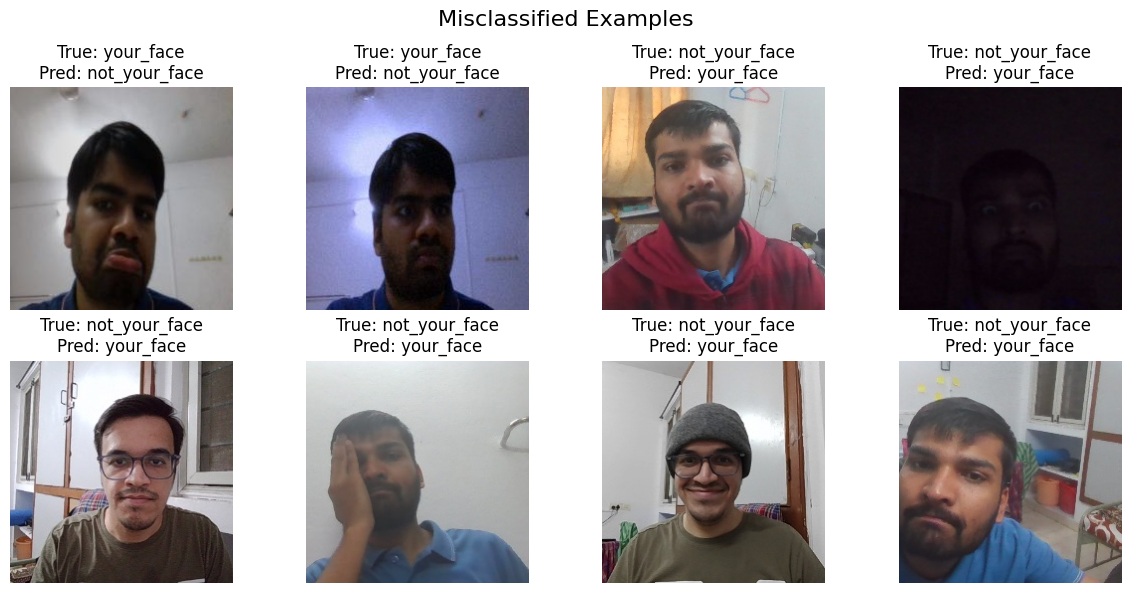

In [10]:
# ─── Cell 14: Qualitative Misclassification Examples ────────────────────────
import matplotlib.pyplot as plt
from torchvision.datasets.folder import default_loader

misclassified = []
for idx in test_ds.indices:
    img_path, true_lbl = full_ds.samples[idx]
    img_tensor = val_tf(default_loader(img_path)).unsqueeze(0).to(DEVICE)
    pred_lbl = model(img_tensor).argmax(1).item()
    if pred_lbl != true_lbl:
        misclassified.append((img_path, true_lbl, pred_lbl))
    if len(misclassified) >= 8:
        break

plt.figure(figsize=(12,6))
for i,(p,t,r) in enumerate(misclassified):
    ax = plt.subplot(2,4,i+1)
    ax.imshow(plt.imread(p))
    ax.set_title(f"True: {full_ds.classes[t]}\nPred: {full_ds.classes[r]}")
    ax.axis('off')
plt.suptitle("Misclassified Examples", size=16)
plt.tight_layout()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_74/3410172077.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

=== Classification Report ===
               precision    recall  f1-score   support

not_your_face     0.9521    0.9586    0.9553       290
    your_face     0.9636    0.9578    0.9607       332

     accuracy                         0.9582       622
    macro avg     0.9578    0.9582    0.9580       622
 weighted avg     0.9582    0.9582    0.9582       622



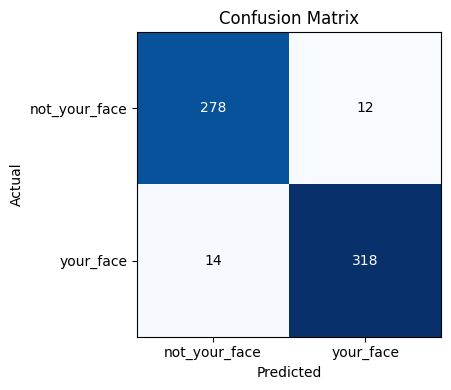

In [11]:
# ─── Cell 15: Test‐Set Metrics & Confusion Matrix ───────────────────────────
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Load best model (example here with VGG-FT; repeat for other models as needed)
model = get_model('vgg16_ft')
model.load_state_dict(torch.load('vgg16_ft_best.pth'))
model.eval()

# Gather predictions
all_preds, all_true = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        out = model(X)
        all_preds.extend(out.argmax(1).cpu().tolist())
        all_true.extend(y.cpu().tolist())

# Classification report
print("=== Classification Report ===")
print(classification_report(
    all_true, all_preds,
    target_names=full_ds.classes,
    digits=4,
    zero_division=0
))

# Confusion matrix plot
cm = confusion_matrix(all_true, all_preds, labels=[0,1])
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(full_ds.classes); ax.set_yticklabels(full_ds.classes)
for i in [0,1]:
    for j in [0,1]:
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i,j]>cm.max()/2 else "black")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()


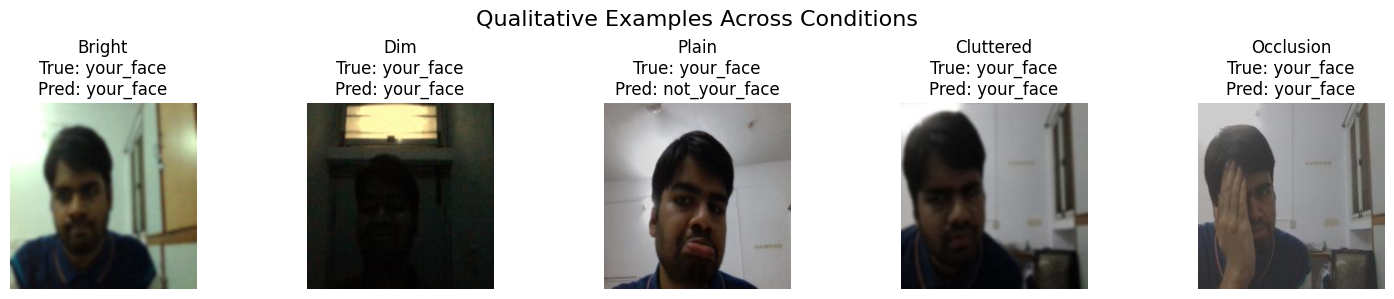

In [12]:
# ─── Cell 16: Qualitative Analysis per Condition ───────────────────────────
import matplotlib.pyplot as plt
from torchvision.datasets.folder import default_loader
import random

conditions = ['bright','dim','plain','cluttered','occlusion']
examples = []

# For each condition, pick one mis‐ or correctly classified example to see the pattern
for cond in conditions:
    for idx in test_ds.indices:
        path, true_lbl = full_ds.samples[idx]
        if cond in path.lower():
            img = default_loader(path)
            tensor = val_tf(img).unsqueeze(0).to(DEVICE)
            pred_lbl = model(tensor).argmax(1).item()
            examples.append((path, cond, pred_lbl, true_lbl))
            break

# Display them
plt.figure(figsize=(15,3))
for i, (path, cond, pred, true) in enumerate(examples):
    ax = plt.subplot(1, len(examples), i+1)
    ax.imshow(plt.imread(path))
    ax.set_title(f"{cond.capitalize()}\nTrue: {full_ds.classes[true]}\nPred: {full_ds.classes[pred]}")
    ax.axis('off')
plt.suptitle("Qualitative Examples Across Conditions", size=16)
plt.tight_layout()
plt.show()


In [13]:
# ─── Cell 17: Evaluation Video of Predicted Labels ─────────────────────────
import cv2, subprocess
from IPython.display import HTML

# 1. Generate raw MP4
raw_vid = 'eval_predictions.mp4'
fourcc  = cv2.VideoWriter_fourcc(*'mp4v')
fps, w, h = 2, IMG_SIZE, IMG_SIZE
writer  = cv2.VideoWriter(raw_vid, fourcc, fps, (w, h))

for idx in test_ds.indices[:50]:
    path, _ = full_ds.samples[idx]
    frame = cv2.imread(path)
    frame = cv2.resize(frame, (w, h))
    tensor = val_tf(default_loader(path)).unsqueeze(0).to(DEVICE)
    pred   = full_ds.classes[model(tensor).argmax(1).item()]
    cv2.putText(frame, pred, (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    writer.write(frame)
writer.release()

# 2. Transcode to H.264
h264_vid = 'eval_predictions_h264.mp4'
subprocess.run([
    'ffmpeg','-y','-i', raw_vid,
    '-c:v','libx264','-preset','slow','-crf','18',
    '-pix_fmt','yuv420p','-movflags','+faststart',
    h264_vid
], check=True)

# 3. Log to W&B (ensure wandb.init() was called earlier)
wandb.log({
    "evaluation_video": wandb.Video(
        h264_vid,
        caption="Test‐set Predictions",
        format="mp4"
    )
})

# 4. Embed inline
HTML(f"""
<video width=400 controls>
  <source src="{h264_vid}" type="video/mp4">
  Your browser does not support MP4.
</video>
""")


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [14]:
# ─── Cell 18: Unlock Simulation Video & W&B Logging ────────────────────────
import cv2
import subprocess
from IPython.display import HTML

# 1. Generate raw MP4
raw_vid = 'unlock_sim.mp4'
fourcc  = cv2.VideoWriter_fourcc(*'mp4v')
fps, w, h = 2, IMG_SIZE, IMG_SIZE
writer  = cv2.VideoWriter(raw_vid, fourcc, fps, (w,h))

for idx in test_ds.indices[:60]:
    path, _ = full_ds.samples[idx]
    frame = cv2.imread(path)
    frame = cv2.resize(frame, (w,h))
    tensor = val_tf(default_loader(path)).unsqueeze(0).to(DEVICE)
    pred   = model(tensor).argmax(1).item()
    status = "Unlocked" if pred==1 else "Locked"
    color  = (0,255,0) if status=="Unlocked" else (0,0,255)
    cv2.putText(frame, status, (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    writer.write(frame)
writer.release()

# 2. Transcode to H.264
h264_vid = 'unlock_sim_h264.mp4'
subprocess.run([
    'ffmpeg','-y','-i', raw_vid,
    '-c:v','libx264','-preset','slow','-crf','18',
    '-pix_fmt','yuv420p','-movflags','+faststart',
    h264_vid
], check=True)

# 3. Log to W&B and embed
wandb.log({
    "unlock_simulation": wandb.Video(
        h264_vid, caption="Phone Unlock Simulation", fps=fps, format="mp4"
    )
})
HTML(f"""
<video width=400 controls>
  <source src="{h264_vid}" type="video/mp4">
  Your browser does not support MP4.
</video>
""")


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [15]:
# ─── Cell D: Generate & Save Videos of Predictions for Each Model ──────────
import cv2
import subprocess

def make_video(model_name, fname):
    m = get_model(model_name)
    m.load_state_dict(torch.load(f"{model_name}_best.pth", weights_only=True))
    m.eval()
    raw = f"{model_name}_raw.mp4"
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(raw, fourcc, 2, (IMG_SIZE, IMG_SIZE))
    for idx in test_ds.indices[:60]:
        path, _ = full_ds.samples[idx]
        frame = cv2.imread(path)
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        tensor = val_tf(default_loader(path)).unsqueeze(0).to(DEVICE)
        pred = full_ds.classes[m(tensor).argmax(1).item()]
        cv2.putText(frame, pred, (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        writer.write(frame)
    writer.release()
    # transcode
    h264 = f"{model_name}.mp4"
    subprocess.run([
        'ffmpeg','-y','-i', raw,
        '-c:v','libx264','-preset','slow','-crf','18',
        '-pix_fmt','yuv420p','-movflags','+faststart',
        h264
    ], check=True)
    return h264

videos = {}
for name in ['vgg16_ft','resnet18_scratch','resnet18_pretrained']:
    videos[name] = make_video(name, f"{name}.mp4")
    print(f"Saved video for {name}: {videos[name]}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --e

Saved video for vgg16_ft: vgg16_ft.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Saved video for resnet18_scratch: resnet18_scratch.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Saved video for resnet18_pretrained: resnet18_pretrained.mp4


[mp4 @ 0x5990ad550080] Starting second pass: moving the moov atom to the beginning of the file
frame=   60 fps=0.0 q=-1.0 Lsize=     553kB time=00:00:28.50 bitrate= 158.8kbits/s speed=45.8x    
video:551kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.215371%
[libx264 @ 0x5990ad54ec00] frame I:6     Avg QP:11.61  size: 10642
[libx264 @ 0x5990ad54ec00] frame P:51    Avg QP:14.50  size:  9303
[libx264 @ 0x5990ad54ec00] frame B:3     Avg QP:14.48  size:  8545
[libx264 @ 0x5990ad54ec00] consecutive B-frames: 90.0% 10.0%  0.0%  0.0%
[libx264 @ 0x5990ad54ec00] mb I  I16..4:  3.2% 78.0% 18.8%
[libx264 @ 0x5990ad54ec00] mb P  I16..4:  4.7% 73.9% 11.1%  P16..4:  6.1%  2.5%  1.7%  0.0%  0.0%    skip: 0.1%
[libx264 @ 0x5990ad54ec00] mb B  I16..4:  5.4% 40.6% 15.1%  B16..8: 15.6% 13.9%  5.5%  direct: 3.7%  skip: 0.0%  L0:70.1% L1:26.4% BI: 3.5%
[libx264 @ 0x5990ad54ec00] 8x8 transform intra:81.4% inter:81.0%
[libx264 @ 0x5990ad54ec00] direct mvs  spatial:0.0% tempo

In [17]:
# ─── Cell E: Embed the Three Videos in-Notebook ────────────────────────────
from IPython.display import HTML

for model_name, vid in videos.items():
    display(HTML(f"""
    <h4>{model_name} Predictions</h4>
    <video width="400" controls>
      <source src="{vid}" type="video/mp4">
    </video>
    """))


In [21]:
# ─── Cell F: Log All Three Prediction Videos to W&B ─────────────────────────
import wandb

# Ensure an active W&B run
if wandb.run is None:
    wandb.init(project="face_recognition", resume="allow")

# Paths to your generated H.264 videos
video_paths = {
    'VGG16-FT':           'vgg16_ft.mp4',
    'ResNet18-Scratch':   'resnet18_scratch.mp4',
    'ResNet18-Pretrained':'resnet18_pretrained.mp4'
}

# Log each as a wandb.Video
to_log = {}
for name, path in video_paths.items():
    to_log[f"{name}_predictions"] = wandb.Video(
        path,
        caption=f"{name} Test‐Set Predictions",
        format="mp4"
    )

wandb.log(to_log)


wandb.finish()
